# <ins>Projet 7 : Implémentez un modèle de scoring</ins>

## **Sommaire**

- [Introduction](#Introduction)
- [1. Importer les librairies et les donnees](#1.-Importer-les-librairies-et-les-donnees) 
- [2. La partie feature engineering](#2.-La-partie-feature-engineering) 
- [3. Entrainer les modeles de classification](#3.-Entrainer-les-modeles-de-classification) 
  - [3.1. model_xgb](#3.1.-model_xgb) 
  - [3.2. model_random_forest](#3.2.-model_random_forest) 
  - [3.3. model_gradient_boosting_classifier](#3.3.-model_gradient_boosting_classifier) 
- [4. Tracker les modeles et creation du registre avec Mlflow](#4.-Tracker-les-modeles-et-creation-du-registre-avec-Mlflow) 
  - [4.1. Mlflow_xgb](#4.1.-Mlflow_xgb) 
  - [4.2. Mlflow_random_forest](#4.2.-Mlflow_random_forest) 
  - [4.3. Mlflow_gradient_boosting_classifier](#4.3.-Mlflow_gradient_boosting_classifier) 







## Introduction

## 1. Importer les librairies et les donnees


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import gc
from sklearn.impute import SimpleImputer
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import shap
shap.initjs() # cette ligne est nécessaire pour avoir la visualisation de la librairie Shap
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import joblib

<p style="text-align:justify">
Comme la taille des données est énorme, on peut utiliser la fonction reduce_mem_usage() afin de réduire la taille et lire les fichiers. Cette fonction est sur le site <a href="https://www.kaggle.com/code/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763" target="_blank">Kaggle</a>. La procédure utilisée sur ce site nous permet également de combiner les fichiers des données et avoir le résultat final dans un seul dataframe. Les données sont dèjà séparées entre test et train data. Ce qui donne la différence entre les train et test est le TARGET. TARGET contient les classes binaires des clients. La mission sera de trouver la classification pour test data. Donc, à la fin dans le résultat final combiné des données : Quand le TARGET a des valeurs 0 ou 1, c'est à dire que ce sont les données train. Quand le TARGET est nan, c'est à dire ce sont les données test. A noter que ce résultat n'a pas utilisé les features engineering qui veut dire qu'on ne peut pas profiter aux maximum des données disposées. La relation entre les données est sur le schéma <a href="https://www.kaggle.com/c/home-credit-default-risk/data" target="_blank">Kaggle</a>.

</p>

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
       
        1. Iterate over every column
        2. Determine if the column is numeric
        3. Determine if the column can be represented by an integer
        4. Find the min and the max value
        5. Determine and apply the smallest datatype that can fit the range of values

    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [3]:
train = import_data('./Data projet 7/application_train.csv')


Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%


In [4]:
test = import_data('./Data projet 7/application_test.csv')


Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%


In [5]:
bureau = import_data('./Data projet 7/bureau.csv')


Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%


In [6]:
bureau_balance = import_data('./Data projet 7/bureau_balance.csv')


Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%


In [7]:
previous_application = import_data('./Data projet 7/previous_application.csv')


Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%


In [8]:
credit_card_balance = import_data('./Data projet 7/credit_card_balance.csv')


Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%


In [9]:
installments_payments = import_data('./Data projet 7/installments_payments.csv')


Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [10]:
POS_CASH_balance = import_data('./Data projet 7/POS_CASH_balance.csv')


Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%


In [11]:
data = train.append(test)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [12]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})

In [13]:
data = data.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')


In [14]:
# first define the formula for grouping rows by ID and calculating mean values
def extract_mean(x):
    y = x.groupby('SK_ID_BUREAU', as_index=False).mean().add_prefix('BUR_BAL_MEAN_') 
    return y

In [15]:
# apply formula to create bureau_balance dataframe grouped by SK_ID_BUREAU with mean values of all numerical columns
bureau_bal_mean = extract_mean(bureau_balance)

In [16]:
bureau_bal_mean = bureau_bal_mean.rename(columns = {'BUR_BAL_MEAN_SK_ID_BUREAU' : 'SK_ID_BUREAU'})

In [17]:
bureau = bureau.merge(bureau_bal_mean, on = 'SK_ID_BUREAU', how = 'left')
bureau.drop('SK_ID_BUREAU', axis = 1, inplace = True) # we don't need this internal ID anymore

In [18]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_') # note that we have changed the ID to group by and the prefix to add
    return y

In [19]:
bureau_mean_values = extract_mean(bureau)
bureau_mean_values = bureau_mean_values.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})

In [20]:
data = data.merge(bureau_mean_values, on = 'SK_ID_CURR', how = 'left')


In [21]:
credit_card_balance.drop('SK_ID_CURR', axis = 1, inplace = True)
installments_payments.drop('SK_ID_CURR', axis = 1, inplace = True)
POS_CASH_balance.drop('SK_ID_CURR', axis = 1, inplace = True)

In [22]:
previous_application_counts = previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})

In [23]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
    return y

credit_card_balance_mean = extract_mean(credit_card_balance)

credit_card_balance_mean = credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [24]:
previous_application = previous_application.merge(credit_card_balance_mean, on = 'SK_ID_PREV', how = 'left')

In [25]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
    return y

install_pay_mean = extract_mean(installments_payments)

install_pay_mean = install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [26]:
previous_application = previous_application.merge(install_pay_mean, on = 'SK_ID_PREV', how = 'left')

In [27]:
def extract_mean(x):
    y = x.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
    return y

POS_mean = extract_mean(POS_CASH_balance)

POS_mean = POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'})

In [28]:
previous_application = previous_application.merge(POS_mean, on = 'SK_ID_PREV', how = 'left')

In [29]:
def extract_mean(x):
    y = x.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
    return y

prev_appl_mean = extract_mean(previous_application)

prev_appl_mean = prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})

prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis = 1) # we don't need this intermediate column any more

In [30]:
data = data.merge(prev_appl_mean, on = 'SK_ID_CURR', how = 'left')


In [31]:
data

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002     1.0         Cash loans           M            N   
1           100003     0.0         Cash loans           F            N   
2           100004     0.0    Revolving loans           M            Y   
3           100006     0.0         Cash loans           F            N   
4           100007     0.0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
356250      456221     NaN         Cash loans           F            N   
356251      456222     NaN         Cash loans           F            N   
356252      456223     NaN         Cash loans           F            Y   
356253      456224     NaN         Cash loans           M            N   
356254      456250     NaN         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
356250               Y             0          121500.0    412560.0   
356251               N             2          157500.0    622413.0   
356252               Y             1          202500.0    315000.0   
356253               N             0          225000.0    450000.0   
356254               N             0          135000.0    312768.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
356250      17473.5         270000.0   Unaccompanied               Working   
356251      31909.5         495000.0   Unaccompanied  Commercial associate   
356252      33205.5         315000.0   Unaccompanied  Commercial associate   
356253      25128.0         450000.0          Family  Commercial associate   
356254      24709.5         270000.0   Unaccompanied               Working   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
356250  Secondary / secondary special                 Widow   
356251  Secondary / secondary special               Married   
356252  Secondary / secondary special               Married   
356253               Higher education               Married   
356254  Secondary / secondary special               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018799       -9461   
1       House / apartment                    0.003542      -16765   
2       House / apartment                    0.010033      -19046   
3       House / apartment                    0.008018      -19005   
4       House / apartment                    0.028656      -19932   
...                   ...                         ...         ...   
356250  House / apartment                    0.002043      -19970   
356251  House / apartment       

In [32]:
train['TARGET'].unique()

array([1, 0], dtype=int8)

In [33]:
data['TARGET'].unique()

array([ 1.,  0., nan])

In [34]:
data['TARGET'].value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [35]:
data['TARGET'].isna().sum()

48744

<p style="text-align:justify">
Comme j'ai supposé que les données test sont représentées par nan dans le dataframe final data. Cela veut dire, suite à la combinaison des données le longueur des données test est égal au longueur des données dans data où le TARGET est nan.
</p>

In [36]:
len(test) == data['TARGET'].isna().sum()

True

In [37]:
dkvbhjxbcv,x

NameError: name 'dkvbhjxbcv' is not defined

## 2. La partie feature engineering


<p style="text-align:justify">
Pour profiter au maximum des données disposées, on doit transformer les données avec features engineering. Afin de réaliser cette mission, on peut utiliser les features engineering sur le site <a href="https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script" target="_blank">Kernel</a>. Les features engineering ne sont pas combinées, donc il faut combiner les résultats de ces features pour les préparer à l'application pour les modèles de classification. 

</p>

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('./Data projet 7/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('./Data projet 7/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


In [5]:
X0_y = application_train_test()
X0_y

Train samples: 307511, test samples: 48744


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0           0      100002     1.0            0             0                0   
1           1      100003     0.0            1             0                1   
2           2      100004     0.0            0             1                0   
3           3      100006     0.0            1             0                0   
4           4      100007     0.0            0             0                0   
...       ...         ...     ...          ...           ...              ...   
356250  48739      456221     NaN            1             0                0   
356251  48740      456222     NaN            1             0                1   
356252  48741      456223     NaN            1             1                0   
356253  48742      456224     NaN            0             0                1   
356254  48743      456250     NaN            1             1                1   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
356250             0          121500.0    412560.0      17473.5   
356251             2          157500.0    622413.0      31909.5   
356252             1          202500.0    315000.0      33205.5   
356253             0          225000.0    450000.0      25128.0   
356254             0          135000.0    312768.0      24709.5   

        AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0              351000.0                    0.018801       -9461   
1             1129500.0                    0.003541      -16765   
2              135000.0                    0.010032      -19046   
3              297000.0                    0.008019      -19005   
4              513000.0                    0.028663      -19932   
...                 ...                         ...         ...   
356250         270000.0                    0.002042      -19970   
356251         495000.0                    0.035792      -11186   
356252         315000.0                    0.026392      -15922   
356253         450000.0                    0.018850      -13968   
356254         270000.0                    0.006629      -13962   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0              -637.0            -3648.0            -2120          NaN   
1             -1188.0            -1186.0             -291          NaN   
2              -225.0            -4260.0            -2531         26.0   
3             -3039.0            -9833.0            -2437          NaN   
4             -3038.0            -4311.0            -3458          NaN   
...               ...                ...              ...          ...   
356250        -5169.0            -9094.0            -3399          NaN   
356251        -1149.0            -3015.0            -3003          NaN   
356252        -3037.0            -2681.0            -1504          4.0   
356253        -2731.0            -1461.0            -1364          NaN   
356254         -633.0            -1072.0            -4220         22.0   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
0                1               1                0                 1   
1                1               1                0                 1   
2                1               1                1                 1   
3                1               1                0                 1   
4                1               1                0                 1   
...            ...             ...              ...               ...   
356250           1       

In [6]:
Xy_0 = X0_y.set_index('SK_ID_CURR', drop=True).drop(columns=['index'])
Xy_0['TARGET'] = Xy_0['TARGET'].replace(np.nan, 'test')
Xy_0

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002        1.0            0             0                0             0   
100003        0.0            1             0                1             0   
100004        0.0            0             1                0             0   
100006        0.0            1             0                0             0   
100007        0.0            0             0                0             0   
...           ...          ...           ...              ...           ...   
456221       test            1             0                0             0   
456222       test            1             0                1             2   
456223       test            1             1                0             1   
456224       test            0             0                1             0   
456250       test            1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   
...                                ...         ...            ...   
456221                        0.002042      -19970        -5169.0   
456222                        0.035792      -11186        -1149.0   
456223                        0.026392      -15922        -3037.0   
456224                        0.018850      -13968        -2731.0   
456250                        0.006629      -13962         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   
...                       ...              ...          ...         ...   
456221                -9094.0            -3399          NaN           1   
456222                -3015.0            -3003          NaN           1   
456223                -2681.0            -1504          4.0           1   
456224                -1461.0            -1364          NaN           1   
456250                -1072.0            -4220         22.0           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                           

In [7]:
sum(Xy_0['TARGET'] == 'test')

48744

In [8]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('./Data projet 7/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('./Data projet 7/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [9]:
X1 = bureau_and_balance()
X1

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  \
SK_ID_CURR                                                                      
100001                     -1572                   -49            -735.000000   
100002                     -1437                  -103            -874.000000   
100003                     -2586                  -606           -1400.750000   
100004                     -1326                  -408            -867.000000   
100005                      -373                   -62            -190.666667   
...                          ...                   ...                    ...   
456249                     -2713                  -483           -1667.076923   
456250                     -1002                  -760            -862.000000   
456253                      -919                  -713            -867.500000   
456254                     -1104                 -1104           -1104.000000   
456255                     -2337                  -363           -1089.454545   

            BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  \
SK_ID_CURR                                                       
100001             240043.666667                       -1329.0   
100002             186150.000000                       -1072.0   
100003             827783.583333                       -2434.0   
100004             421362.000000                        -595.0   
100005              26340.333333                        -128.0   
...                          ...                           ...   
456249             407302.243590                       -2499.0   
456250              15724.000000                        -272.0   
456253              10609.000000                        -189.0   
456254                       NaN                        -859.0   
456255             502786.672727                       -1243.0   

            BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  \
SK_ID_CURR                                                                
100001                            1778.0                      82.428571   
100002                             780.0                    -349.000000   
100003                            1216.0                    -544.500000   
100004                            -382.0                    -488.500000   
100005                            1324.0                     439.333333   
...                                  ...                            ...   
456249                            1363.0                   -1232.333333   
456250                            2340.0                    1288.333333   
456253                            1113.0                     280.500000   
456254                            -859.0                    -859.000000   
456255                           27320.0                    3231.272727   

            BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  \
SK_ID_CURR                                                              
100001                        -93.142857                            0   
100002                       -499.875000                            0   
100003                       -816.000000                            0   
100004                       -532.000000                            0   
100005                        -54.333333                            0   
...                                  ...                          ...   
456249                      -1064.538462                            0   
456250                        -60.333333                            0   
456253                       -253.250000                            0   
456254                       -401.000000                            0   
456255                       -531.090909                            0   

            BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  \
SK_ID_CURR                                                                   
100001           

In [10]:
Xy_1 = Xy_0.join(X1)
Xy_1

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002        1.0            0             0                0             0   
100003        0.0            1             0                1             0   
100004        0.0            0             1                0             0   
100006        0.0            1             0                0             0   
100007        0.0            0             0                0             0   
...           ...          ...           ...              ...           ...   
456221       test            1             0                0             0   
456222       test            1             0                1             2   
456223       test            1             1                0             1   
456224       test            0             0                1             0   
456250       test            1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   
...                                ...         ...            ...   
456221                        0.002042      -19970        -5169.0   
456222                        0.035792      -11186        -1149.0   
456223                        0.026392      -15922        -3037.0   
456224                        0.018850      -13968        -2731.0   
456250                        0.006629      -13962         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   
...                       ...              ...          ...         ...   
456221                -9094.0            -3399          NaN           1   
456222                -3015.0            -3003          NaN           1   
456223                -2681.0            -1504          4.0           1   
456224                -1461.0            -1364          NaN           1   
456250                -1072.0            -4220         22.0           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                           

In [11]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('./Data projet 7/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [12]:
X2 = previous_applications()
X2

PREV_AMT_ANNUITY_MIN  PREV_AMT_ANNUITY_MAX  PREV_AMT_ANNUITY_MEAN  \
SK_ID_CURR                                                                      
100001                  3951.000              3951.000            3951.000000   
100002                  9251.775              9251.775            9251.775000   
100003                  6737.310             98356.995           56553.990000   
100004                  5357.250              5357.250            5357.250000   
100005                  4813.200              4813.200            4813.200000   
...                          ...                   ...                    ...   
456251                  6605.910              6605.910            6605.910000   
456252                 10074.465             10074.465           10074.465000   
456253                  3973.095              5567.715            4770.405000   
456254                  2296.440             19065.825           10681.132500   
456255                  2250.000             54022.140           20775.391875   

            PREV_AMT_APPLICATION_MIN  PREV_AMT_APPLICATION_MAX  \
SK_ID_CURR                                                       
100001                       24835.5                   24835.5   
100002                      179055.0                  179055.0   
100003                       68809.5                  900000.0   
100004                       24282.0                   24282.0   
100005                           0.0                   44617.5   
...                              ...                       ...   
456251                       40455.0                   40455.0   
456252                       57595.5                   57595.5   
456253                       19413.0                   28912.5   
456254                       18846.0                  223789.5   
456255                       45000.0                 1170000.0   

            PREV_AMT_APPLICATION_MEAN  PREV_AMT_CREDIT_MIN  \
SK_ID_CURR                                                   
100001                      24835.500              23787.0   
100002                     179055.000             179055.0   
100003                     435436.500              68053.5   
100004                      24282.000              20106.0   
100005                      22308.750                  0.0   
...                               ...                  ...   
456251                      40455.000              40455.0   
456252                      57595.500              56821.5   
456253                      24162.750              13945.5   
456254                     121317.750              21456.0   
456255                     362770.875              45000.0   

            PREV_AMT_CREDIT_MAX  PREV_AMT_CREDIT_MEAN  \
SK_ID_CURR                                              
100001                  23787.0              23787.00   
100002                 179055.0             179055.00   
100003                1035882.0             484191.00   
100004                  20106.0              20106.00   
100005                  40153.5              20076.75   
...                         ...                   ...   
456251                  40455.0              40455.00   
456252                  56821.5              56821.50   
456253                  27306.0              20625.75   
456254                 247423.5             134439.75   
456255                1271929.5             424431.00   

            PREV_APP_CREDIT_PERC_MIN  PREV_APP_CREDIT_PERC_MAX  \
SK_ID_CURR                                                       
100001                      1.044079                  1.044079   
100002                      1.000000                  1.000000   
100003                      0.868825                  1.011109   
100004                      1.207699                  1.207699   
100005                      1.111173                  1.111173   
...                              ...                       ...   
456251                

In [13]:
Xy_2 = Xy_1.join(X2)
Xy_2

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002        1.0            0             0                0             0   
100003        0.0            1             0                1             0   
100004        0.0            0             1                0             0   
100006        0.0            1             0                0             0   
100007        0.0            0             0                0             0   
...           ...          ...           ...              ...           ...   
456221       test            1             0                0             0   
456222       test            1             0                1             2   
456223       test            1             1                0             1   
456224       test            0             0                1             0   
456250       test            1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   
...                                ...         ...            ...   
456221                        0.002042      -19970        -5169.0   
456222                        0.035792      -11186        -1149.0   
456223                        0.026392      -15922        -3037.0   
456224                        0.018850      -13968        -2731.0   
456250                        0.006629      -13962         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   
...                       ...              ...          ...         ...   
456221                -9094.0            -3399          NaN           1   
456222                -3015.0            -3003          NaN           1   
456223                -2681.0            -1504          4.0           1   
456224                -1461.0            -1364          NaN           1   
456250                -1072.0            -4220         22.0           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                           

In [14]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('./Data projet 7/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [15]:
X3 = pos_cash()
X3

POS_MONTHS_BALANCE_MAX  POS_MONTHS_BALANCE_MEAN  \
SK_ID_CURR                                                    
100001                         -53               -72.555556   
100002                          -1               -10.000000   
100003                         -18               -43.785714   
100004                         -24               -25.500000   
100005                         -15               -20.000000   
...                            ...                      ...   
456251                          -1                -5.000000   
456252                         -76               -79.000000   
456253                         -57               -79.235294   
456254                          -1                -5.550000   
456255                          -2               -16.408451   

            POS_MONTHS_BALANCE_SIZE  POS_SK_DPD_MAX  POS_SK_DPD_MEAN  \
SK_ID_CURR                                                             
100001                            9               7         0.777778   
100002                           19               0         0.000000   
100003                           28               0         0.000000   
100004                            4               0         0.000000   
100005                           11               0         0.000000   
...                             ...             ...              ...   
456251                            9               0         0.000000   
456252                            7               0         0.000000   
456253                           17               5         0.294118   
456254                           20               0         0.000000   
456255                           71               5         0.070423   

            POS_SK_DPD_DEF_MAX  POS_SK_DPD_DEF_MEAN  \
SK_ID_CURR                                            
100001                       7             0.777778   
100002                       0             0.000000   
100003                       0             0.000000   
100004                       0             0.000000   
100005                       0             0.000000   
...                        ...                  ...   
456251                       0             0.000000   
456252                       0             0.000000   
456253                       5             0.294118   
456254                       0             0.000000   
456255                       5             0.070423   

            POS_NAME_CONTRACT_STATUS_Active_MEAN  \
SK_ID_CURR                                         
100001                                  0.777778   
100002                                  1.000000   
100003                                  0.928571   
100004                                  0.750000   
100005                                  0.818182   
...                                          ...   
456251                                  0.777778   
456252                                  0.857143   
456253                                  0.882353   
456254                                  1.000000   
456255                                  0.915493   

            POS_NAME_CONTRACT_STATUS_Amortized debt_MEAN  \
SK_ID_CURR                                                 
100001                                               0.0   
100002                                               0.0   
100003                                               0.0   
100004                                               0.0   
100005                                               0.0   
...                                                  ...   
456251                                               0.0   
456252                                               0.0   
456253                                               0.0   
456254                                               0.0   
456255                                               0.0   

            POS_NAME_CONTRACT_STATUS_Approved_MEAN  \
SK_ID_CURR                 

In [16]:
Xy_3 = Xy_2.join(X3)
Xy_3

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002        1.0            0             0                0             0   
100003        0.0            1             0                1             0   
100004        0.0            0             1                0             0   
100006        0.0            1             0                0             0   
100007        0.0            0             0                0             0   
...           ...          ...           ...              ...           ...   
456221       test            1             0                0             0   
456222       test            1             0                1             2   
456223       test            1             1                0             1   
456224       test            0             0                1             0   
456250       test            1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   
...                                ...         ...            ...   
456221                        0.002042      -19970        -5169.0   
456222                        0.035792      -11186        -1149.0   
456223                        0.026392      -15922        -3037.0   
456224                        0.018850      -13968        -2731.0   
456250                        0.006629      -13962         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   
...                       ...              ...          ...         ...   
456221                -9094.0            -3399          NaN           1   
456222                -3015.0            -3003          NaN           1   
456223                -2681.0            -1504          4.0           1   
456224                -1461.0            -1364          NaN           1   
456250                -1072.0            -4220         22.0           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                           

In [17]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('./Data projet 7/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('./Data projet 7/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [18]:
X4 = installments_payments()
X4

INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE  INSTAL_DPD_MAX  \
SK_ID_CURR                                                          
100001                                          2            11.0   
100002                                          2             0.0   
100003                                          2             0.0   
100004                                          2             0.0   
100005                                          2             1.0   
...                                           ...             ...   
456251                                          2             0.0   
456252                                          1             3.0   
456253                                          1             9.0   
456254                                          1             0.0   
456255                                          4             7.0   

            INSTAL_DPD_MEAN  INSTAL_DPD_SUM  INSTAL_DBD_MAX  INSTAL_DBD_MEAN  \
SK_ID_CURR                                                                     
100001             1.571429            11.0            36.0         8.857143   
100002             0.000000             0.0            31.0        20.421053   
100003             0.000000             0.0            14.0         7.160000   
100004             0.000000             0.0            11.0         7.666667   
100005             0.111111             1.0            37.0        23.666667   
...                     ...             ...             ...              ...   
456251             0.000000             0.0            46.0        36.285714   
456252             0.500000             3.0            11.0         3.333333   
456253             0.642857             9.0            51.0        15.142857   
456254             0.000000             0.0            31.0        19.000000   
456255             0.702703            52.0            35.0         8.770270   

            INSTAL_DBD_SUM  INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MEAN  \
SK_ID_CURR                                                                      
100001                62.0                  1.00000                  1.000000   
100002               388.0                  1.00000                  1.000000   
100003               179.0                  1.00000                  1.000000   
100004                23.0                  1.00000                  1.000000   
100005               213.0                  1.00000                  1.000000   
...                    ...                      ...                       ...   
456251               254.0                  1.00000                  1.000000   
456252                20.0                  1.00000                  1.000000   
456253               212.0                  1.00000                  0.928571   
456254               361.0                  1.00000                  1.000000   
456255               649.0                 12.38847                  1.033463   

            INSTAL_PAYMENT_PERC_SUM  INSTAL_PAYMENT_PERC_VAR  \
SK_ID_CURR                                                     
100001                     7.000000                 0.000000   
100002                    19.000000                 0.000000   
100003                    25.000000                 0.000000   
100004                     3.000000                 0.000000   
100005                     9.000000                 0.000000   
...                             ...                      ...   
456251                     7.000000                 0.000000   
456252                     6.000000                 0.000000   
456253                    13.000000                 0.070380   
456254                    19.000000                 0.000000   
456255                    76.476278                 1.891209   

            INSTAL_PAYMENT_DIFF_MAX  INSTAL_PAYMENT_DIFF_MEAN  \
SK_ID_CURR                                                      
100001                        0.000                   0.

In [19]:
Xy_4 = Xy_3.join(X4)
Xy_4

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                    
100002        1.0            0             0                0             0   
100003        0.0            1             0                1             0   
100004        0.0            0             1                0             0   
100006        0.0            1             0                0             0   
100007        0.0            0             0                0             0   
...           ...          ...           ...              ...           ...   
456221       test            1             0                0             0   
456222       test            1             0                1             2   
456223       test            1             1                0             1   
456224       test            0             0                1             0   
456250       test            1             1                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461         -637.0   
100003                        0.003541      -16765        -1188.0   
100004                        0.010032      -19046         -225.0   
100006                        0.008019      -19005        -3039.0   
100007                        0.028663      -19932        -3038.0   
...                                ...         ...            ...   
456221                        0.002042      -19970        -5169.0   
456222                        0.035792      -11186        -1149.0   
456223                        0.026392      -15922        -3037.0   
456224                        0.018850      -13968        -2731.0   
456250                        0.006629      -13962         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0            -2120          NaN           1   
100003                -1186.0             -291          NaN           1   
100004                -4260.0            -2531         26.0           1   
100006                -9833.0            -2437          NaN           1   
100007                -4311.0            -3458          NaN           1   
...                       ...              ...          ...         ...   
456221                -9094.0            -3399          NaN           1   
456222                -3015.0            -3003          NaN           1   
456223                -2681.0            -1504          4.0           1   
456224                -1461.0            -1364          NaN           1   
456250                -1072.0            -4220         22.0           1   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                           

<p style="text-align:justify">
Vérifier que dans les features engineering il n'y a pas de répétitions : 
</p>

In [20]:
sum(pd.Series(Xy_4.columns).duplicated())

0

<p style="text-align:justify">
Traiter les valeurs inf :
</p>

In [21]:
# Load the data into a dataframe
df = Xy_4.drop(columns=['TARGET'])

# Iterate through each column
for col in df.columns:
    # Replace "inf" values with the max of each column
    df[col] = df[col].replace([np.inf], df[col].replace([np.inf], np.nan).max())

    # Replace "-inf" values with the min of each column
    df[col] = df[col].replace([-np.inf], df[col].replace([-np.inf], np.nan).min())

<p style="text-align:justify">
Traiter les valeurs nan :
</p>

In [22]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(df)
Xy = pd.DataFrame(imp_mean.transform(df))
Xy.columns = df.columns
Xy.index = df.index
Xy['TARGET'] = Xy_4['TARGET']

In [23]:
Xy

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
100002              0.0           0.0              0.0           0.0   
100003              1.0           0.0              1.0           0.0   
100004              0.0           1.0              0.0           0.0   
100006              1.0           0.0              0.0           0.0   
100007              0.0           0.0              0.0           0.0   
...                 ...           ...              ...           ...   
456221              1.0           0.0              0.0           0.0   
456222              1.0           0.0              1.0           2.0   
456223              1.0           1.0              0.0           1.0   
456224              0.0           0.0              1.0           0.0   
456250              1.0           1.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801     -9461.0         -637.0   
100003                        0.003541    -16765.0        -1188.0   
100004                        0.010032    -19046.0         -225.0   
100006                        0.008019    -19005.0        -3039.0   
100007                        0.028663    -19932.0        -3038.0   
...                                ...         ...            ...   
456221                        0.002042    -19970.0        -5169.0   
456222                        0.035792    -11186.0        -1149.0   
456223                        0.026392    -15922.0        -3037.0   
456224                        0.018850    -13968.0        -2731.0   
456250                        0.006629    -13962.0         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0          -2120.0    12.023766         1.0   
100003                -1186.0           -291.0    12.023766         1.0   
100004                -4260.0          -2531.0    26.000000         1.0   
100006                -9833.0          -2437.0    12.023766         1.0   
100007                -4311.0          -3458.0    12.023766         1.0   
...                       ...              ...          ...         ...   
456221                -9094.0          -3399.0    12.023766         1.0   
456222                -3015.0          -3003.0    12.023766         1.0   
456223                -2681.0          -1504.0     4.000000         1.0   
456224                -1461.0          -1364.0    12.023766         1.0   
456250                -1072.0          -4220.0    22.000000         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                 1.0              0.0               1.0         1.0   
100003 

<p style="text-align:justify">
vérifier qu'il n'y a pas des valeurs manquantes :
</p>

In [24]:
Xy.isna().sum()

CODE_GENDER                       0
FLAG_OWN_CAR                      0
FLAG_OWN_REALTY                   0
CNT_CHILDREN                      0
AMT_INCOME_TOTAL                  0
                                 ..
INSTAL_DAYS_ENTRY_PAYMENT_MAX     0
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    0
INSTAL_DAYS_ENTRY_PAYMENT_SUM     0
INSTAL_COUNT                      0
TARGET                            0
Length: 655, dtype: int64

In [25]:
for x in Xy.isna().sum() :
    if x != 0 :
        print(x)

<p style="text-align:justify">
séparer les données entre train et test :
</p>

In [26]:
Xy_train = Xy.loc[Xy['TARGET']!='test']
Xy_train

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
100002              0.0           0.0              0.0           0.0   
100003              1.0           0.0              1.0           0.0   
100004              0.0           1.0              0.0           0.0   
100006              1.0           0.0              0.0           0.0   
100007              0.0           0.0              0.0           0.0   
...                 ...           ...              ...           ...   
456251              0.0           0.0              1.0           0.0   
456252              1.0           0.0              0.0           0.0   
456253              1.0           0.0              0.0           0.0   
456254              1.0           0.0              0.0           0.0   
456255              1.0           0.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456251              157500.0    254700.0      27558.0         225000.0   
456252               72000.0    269550.0      12001.5         225000.0   
456253              153000.0    677664.0      29979.0         585000.0   
456254              171000.0    370107.0      20205.0         319500.0   
456255              157500.0    675000.0      49117.5         675000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801     -9461.0    -637.000000   
100003                        0.003541    -16765.0   -1188.000000   
100004                        0.010032    -19046.0    -225.000000   
100006                        0.008019    -19005.0   -3039.000000   
100007                        0.028663    -19932.0   -3038.000000   
...                                ...         ...            ...   
456251                        0.032561     -9327.0    -236.000000   
456252                        0.025164    -20775.0   -2396.675703   
456253                        0.005002    -14966.0   -7921.000000   
456254                        0.005313    -11961.0   -4786.000000   
456255                        0.046220    -16856.0   -1262.000000   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100002                -3648.0          -2120.0    12.023766         1.0   
100003                -1186.0           -291.0    12.023766         1.0   
100004                -4260.0          -2531.0    26.000000         1.0   
100006                -9833.0          -2437.0    12.023766         1.0   
100007                -4311.0          -3458.0    12.023766         1.0   
...                       ...              ...          ...         ...   
456251                -8456.0          -1982.0    12.023766         1.0   
456252                -4388.0          -4090.0    12.023766         1.0   
456253                -6737.0          -5150.0    12.023766         1.0   
456254                -2562.0           -931.0    12.023766         1.0   
456255                -5128.0           -410.0    12.023766         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                 1.0              0.0               1.0         1.0   
100003 

In [27]:
Xy_test = Xy.loc[Xy['TARGET']=='test']
Xy_test

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
100001              1.0           0.0              0.0           0.0   
100005              0.0           0.0              0.0           0.0   
100013              0.0           1.0              0.0           0.0   
100028              1.0           0.0              0.0           2.0   
100038              0.0           1.0              1.0           1.0   
...                 ...           ...              ...           ...   
456221              1.0           0.0              0.0           0.0   
456222              1.0           0.0              1.0           2.0   
456223              1.0           1.0              0.0           1.0   
456224              0.0           0.0              1.0           0.0   
456250              1.0           1.0              1.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100001              135000.0    568800.0      20560.5         450000.0   
100005               99000.0    222768.0      17370.0         180000.0   
100013              202500.0    663264.0      69777.0         630000.0   
100028              315000.0   1575000.0      49018.5        1575000.0   
100038              180000.0    625500.0      32067.0         625500.0   
...                      ...         ...          ...              ...   
456221              121500.0    412560.0      17473.5         270000.0   
456222              157500.0    622413.0      31909.5         495000.0   
456223              202500.0    315000.0      33205.5         315000.0   
456224              225000.0    450000.0      25128.0         450000.0   
456250              135000.0    312768.0      24709.5         270000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100001                        0.018850    -19241.0        -2329.0   
100005                        0.035792    -18064.0        -4469.0   
100013                        0.019101    -20038.0        -4458.0   
100028                        0.026392    -13976.0        -1866.0   
100038                        0.010032    -13040.0        -2191.0   
...                                ...         ...            ...   
456221                        0.002042    -19970.0        -5169.0   
456222                        0.035792    -11186.0        -1149.0   
456223                        0.026392    -15922.0        -3037.0   
456224                        0.018850    -13968.0        -2731.0   
456250                        0.006629    -13962.0         -633.0   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
100001                -5170.0           -812.0    12.023766         1.0   
100005                -9118.0          -1623.0    12.023766         1.0   
100013                -2175.0          -3503.0     5.000000         1.0   
100028                -2000.0          -4208.0    12.023766         1.0   
100038                -4000.0          -4262.0    16.000000         1.0   
...                       ...              ...          ...         ...   
456221                -9094.0          -3399.0    12.023766         1.0   
456222                -3015.0          -3003.0    12.023766         1.0   
456223                -2681.0          -1504.0     4.000000         1.0   
456224                -1461.0          -1364.0    12.023766         1.0   
456250                -1072.0          -4220.0    22.000000         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100001                 1.0              0.0               1.0         0.0   
100005 

<p style="text-align:justify">
Préparer X_train et y_train pour les modèles  :
</p>

In [28]:
X_train = Xy_train.drop(columns=['TARGET'])
y_train = Xy_train['TARGET'].astype(int)
X_test = Xy_test.drop(columns=['TARGET'])

<p style="text-align:justify">
Préparer X_res et y_res pour les modèles, une des méthodes pour rééquilibrer les données :
</p>

In [29]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


In [30]:
bn,,hb,b,b

SyntaxError: invalid syntax (1696176287.py, line 1)

## 3. Entrainer les modeles de classification

### 3.1. model_xgb


In [ ]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

<p style="text-align:justify">
Prévoir les classes pour test data :
</p>

In [ ]:
y_predicted_xgb = pd.Series(model_xgb.predict(X_test))
y_predicted_xgb.value_counts()

0    48394
1      350
dtype: int64

<p style="text-align:justify">
Rééquilibrer les données avec SMOTE :
</p>

In [ ]:
model_xgb.fit(X_res, y_res)
y_predicted_xgb = pd.Series(model_xgb.predict(X_test))
y_predicted_xgb.value_counts()

0    48381
1      363
dtype: int64

<p style="text-align:justify">
On remarque que la répartition des classes est mieux équilibré que la précédente.
</p>

<p style="text-align:justify">
La fonction coût métier et calculer les scores :
</p>

In [ ]:
def cost(y_true, y_predicted):
    '''_Use the function cost() to obtain the score of cost function_.
    Args:
        y_true (array, optional): _The true values of calsses_. 
        y_predicted (array, optional): _The predicted values of calsses_. 
                 
    Returns:
        score: _The score of cost function_.
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_predicted).ravel()
    fn_value = -10
    tn_value = 1
    gain = tn*tn_value + fn*fn_value
    max_gain = tn*tn_value
    baseline = (tn+fp)*tn_value + (tp+fn)*fn_value
    score = (gain-baseline) / (max_gain-baseline)
    return score

<p style="text-align:justify">
Ici, je définis les test et train data pour calculer les scores. Car pour calculer les scores, on a besoin de y_true et y_predicted et ce n'est pas possible de les avoir en utilisant X_train et y_train. A noter aussi que je reprend X et y qui ont donné des résultats mieux équilibrés. C'est pour cela, ici je reprends X_res et y_res.
</p>

In [ ]:
X_train_sx, X_test_sx, y_train_sx, y_test_sx = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
model_xgb.fit(X_train_sx, y_train_sx)
y_predicted_sx = model_xgb.predict(X_test_sx)
y_true_sx = y_test_sx
f1_score(y_true_sx, y_predicted_sx)

0.9534798167285375

In [ ]:
roc_auc_score(y_true_sx, model_xgb.predict_proba(X_test_sx)[:, 1])


0.9799446454985647

In [ ]:
cost(y_true_sx, y_predicted_sx)

0.9165324509049109

<p style="text-align:justify">
Feature importance globale :
</p>

In [ ]:
def feature_importance_global(feature_importance, features_names, min_global_score=0.1) :
    '''_Use the function feature_importance_global() to obtain the global features importance_.
    Args:
        feature_importance (array, optional): _The scores of global feature importance_. 
        features_names (array, optional): _The names of features_. 
        min_global_score (float, optional): _minimum global score, the plot starts from this value_. 
                    
    Returns:
        plt.show(): _The global features importance on a plot_.
    '''
    global_scores = pd.DataFrame()
    global_scores['features_importance'] = 100*feature_importance
    global_scores['features_names'] = features_names
    global_scores = global_scores.loc[global_scores['features_importance']>min_global_score]
    global_scores = global_scores.sort_values(by=['features_importance'], ascending=True).reset_index(drop=True)
    plt.figure(figsize=(25, 30))
    bars = plt.barh(global_scores['features_names'], global_scores['features_importance'], height=0.2, color='#FF4040')
    plt.xlabel("Feature Importance", fontsize=20, fontweight='bold')
    plt.ylabel("Feature Name", fontsize=20, fontweight='bold')
    plt.title('Global Feature Importance', size=35, fontweight='bold')
    plt.tick_params(axis='both', which='major', labelsize=10)

    i = 0
    for g in bars:
        width = g.get_width()
        height = g.get_height()
        x, y = g.get_xy()
        plt.text(x+width*1.001, y+height/3, str(global_scores['features_importance'][i]), fontweight='bold', fontsize=8)
        i += 1
    return plt.show()

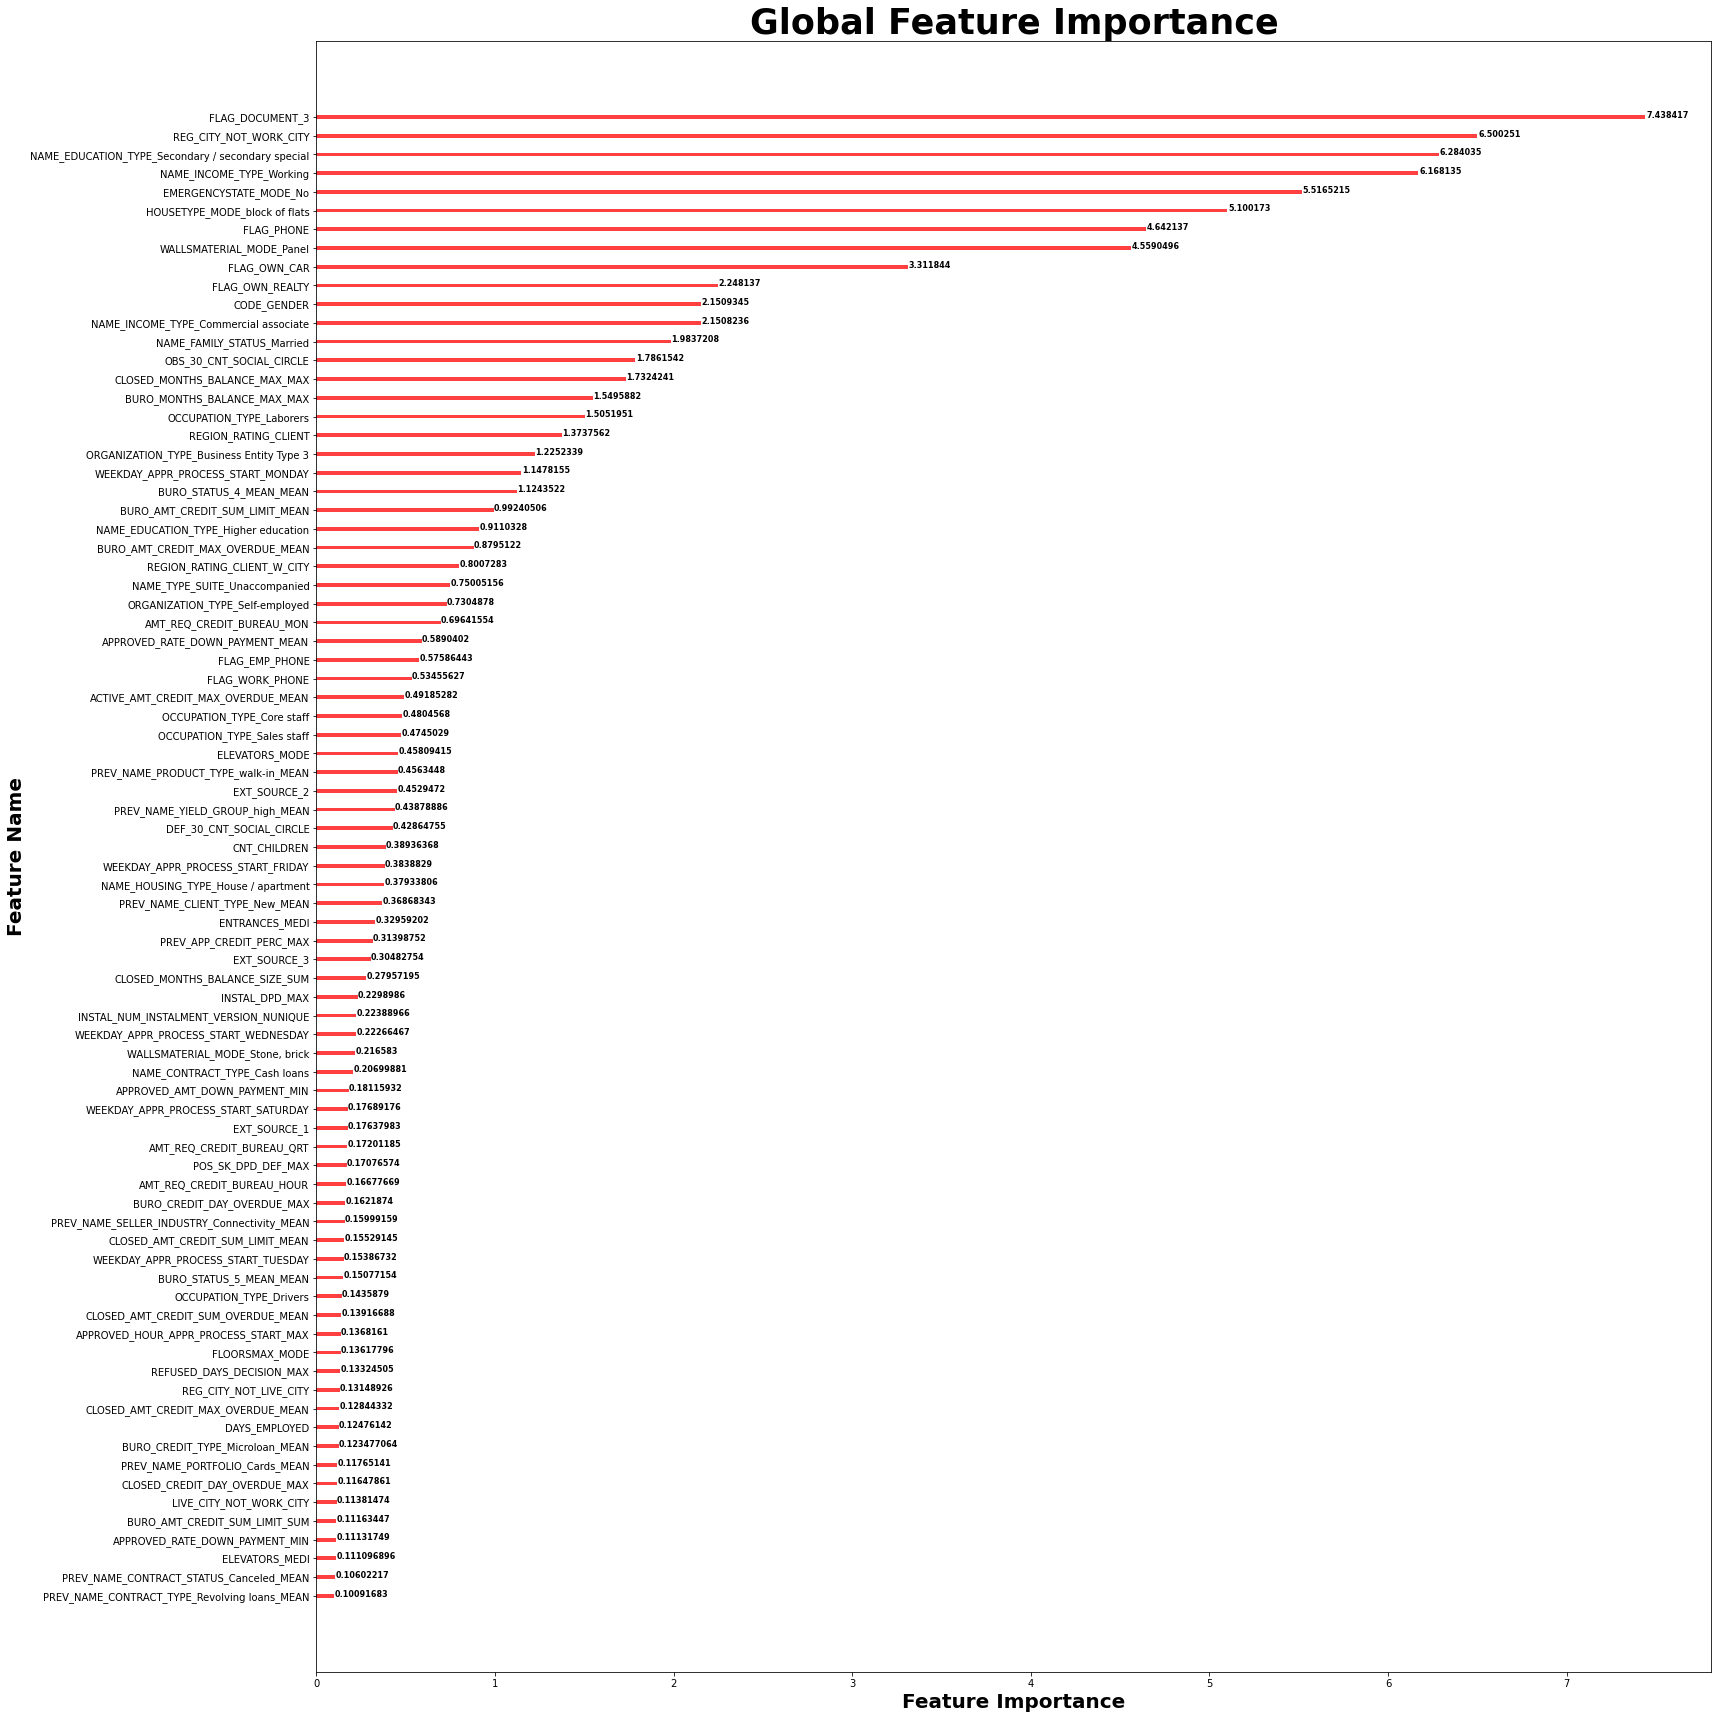

In [ ]:
feature_importance = model_xgb.feature_importances_
features_names = X_test_sx.columns
feature_importance_global(feature_importance, features_names) 

<p style="text-align:justify">
Feature importance local :
</p>

In [ ]:
model_random_forest = RandomForestClassifier(max_depth=2, random_state=0)
def feature_importance_local(X_testlo, X_trainlo, model) :
    '''_Use the function feature_importance_local() to obtain the local feature importance for a random raw_.
    Args:
        X_test (array, optional): _The train features_. 
        X_train (array, optional): _The test features_. 
        model (object, optional): _The used model of classification_. 
                    
    Returns:
        plot: _The local feature importance on a plot_.
    '''
    RandomLine = np.random.randint(0, len(X_testlo)-1)
    test_Random = X_testlo.iloc[RandomLine]
    shap_explainer = shap.TreeExplainer(model)
    shap_values = shap_explainer.shap_values(X_trainlo)
    if model != model_random_forest:
        plot = shap.force_plot(shap_explainer.expected_value, shap_values[1], test_Random)
    else:
        plot = shap.force_plot(shap_explainer.expected_value[1], shap_values[1][1], test_Random)
    return plot

In [ ]:
model = model_xgb
X_testlo = X_test_sx
X_trainlo = X_train_sx
feature_importance_local(X_testlo, X_trainlo, model) 

In [ ]:
cbvcvbcb

NameError: name 'cbvcvbcb' is not defined

In [ ]:
model_xgb = xgb.XGBClassifier()
X_train_sx, X_test_sx, y_train_sx, y_test_sx = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
model_xgb.fit(X_train_sx, y_train_sx)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
model = model_xgb
X_testlo = X_test_sx
X_trainlo = X_train_sx
RandomLine = np.random.randint(0, len(X_testlo)-1)
test_Random = X_testlo.iloc[RandomLine]
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_trainlo)
shap.force_plot(shap_explainer.expected_value, shap_values[1], test_Random)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [ ]:
len(shap_values)

378793

In [ ]:
test_Random

CODE_GENDER                            1.000000
FLAG_OWN_CAR                           0.716293
FLAG_OWN_REALTY                        0.716293
CNT_CHILDREN                           0.000000
AMT_INCOME_TOTAL                  157500.000000
                                      ...      
INSTAL_AMT_PAYMENT_SUM            129328.799474
INSTAL_DAYS_ENTRY_PAYMENT_MAX       -258.075923
INSTAL_DAYS_ENTRY_PAYMENT_MEAN      -402.508147
INSTAL_DAYS_ENTRY_PAYMENT_SUM      -4426.828342
INSTAL_COUNT                          10.581464
Name: 424600, Length: 654, dtype: float64

In [ ]:
X_trainlo

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
970        0.000000      0.000000              0.0      2.000000   
76393      1.000000      0.000000              0.0      2.000000   
28159      0.000000      1.000000              0.0      0.000000   
291329     1.000000      0.000000              0.0      0.000000   
557323     1.000000      0.932101              0.0      0.000000   
...             ...           ...              ...           ...   
110268     0.000000      1.000000              1.0      2.000000   
259178     1.000000      0.000000              0.0      2.000000   
365838     0.149542      0.000000              0.0      0.850458   
131932     0.000000      0.000000              0.0      1.000000   
121958     1.000000      0.000000              0.0      0.000000   

        AMT_INCOME_TOTAL    AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
970        180000.000000  4.360320e+05  20326.500000     3.600000e+05   
76393      108000.000000  3.150000e+05  13522.500000     3.150000e+05   
28159      202500.000000  2.398500e+05  25960.500000     2.250000e+05   
291329      90000.000000  2.700000e+05  13500.000000     2.700000e+05   
557323     253222.184888  6.213036e+05  30109.599826     5.535560e+05   
...                  ...           ...           ...              ...   
110268     112500.000000  4.950000e+05  29605.500000     4.950000e+05   
259178     112500.000000  1.288350e+06  37800.000000     1.125000e+06   
365838     129616.489868  2.932250e+05  22302.552842     2.479624e+05   
131932     202500.000000  3.270240e+05  21420.000000     2.700000e+05   
121958      67500.000000  2.250000e+05  22050.000000     2.250000e+05   

        REGION_POPULATION_RELATIVE    DAYS_BIRTH  DAYS_EMPLOYED  \
970                       0.002506 -15481.000000    -207.000000   
76393                     0.025164 -11731.000000   -1373.000000   
28159                     0.046220 -13546.000000    -285.000000   
291329                    0.019101 -18050.000000   -1757.000000   
557323                    0.018064 -22443.641678   -2415.234193   
...                            ...           ...            ...   
110268                    0.028663 -12960.000000    -120.000000   
259178                    0.016612  -9985.000000   -1738.000000   
365838                    0.025615 -13933.106100    -251.079219   
131932                    0.009334 -11948.000000   -3997.000000   
121958                    0.006852 -24688.000000   -2396.675703   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
970          -1897.000000     -1833.000000    12.023766         1.0   
76393        -5689.000000     -4344.000000    12.023766         1.0   
28159        -5959.000000     -4223.000000     2.000000         1.0   
291329      -10404.000000     -1578.000000    12.023766         1.0   
557323       -1476.806056      -445.333448     1.748504         1.0   
...                   ...              ...          ...         ...   
110268       -4454.000000     -4482.000000    19.000000         1.0   
259178       -2664.000000     -2664.000000    12.023766         1.0   
365838       -6836.851712     -3854.642261    12.023766         1.0   
131932       -2152.000000     -4284.000000    12.023766         1.0   
121958        -851.000000     -4405.000000    12.023766         1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
970           1.000000         1.000000               1.0    1.000000   
76393         1.000000         1.000000               1.0    1.000000   
28159         1.000000         0.000000               1.0    0.000000   
291329        1.000000         0.000000               1.0    0.000000   
557323        0.067899         0.000000               1.0    0.067899   
...                ...              ...               ...         ...   
110268        1.000000         0.000000               1.0    0.000000   
259178        1.000000         0.000000               1.0    0.000000   

In [ ]:
X_trainlo.iloc[0:2]

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
970            0.0           0.0              0.0           2.0   
76393          1.0           0.0              0.0           2.0   

       AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
970            180000.0    436032.0      20326.5         360000.0   
76393          108000.0    315000.0      13522.5         315000.0   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
970                      0.002506    -15481.0         -207.0   
76393                    0.025164    -11731.0        -1373.0   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
970              -1897.0          -1833.0    12.023766         1.0   
76393            -5689.0          -4344.0    12.023766         1.0   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
970               1.0              1.0               1.0         1.0   
76393             1.0              1.0               1.0         1.0   

       FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
970           0.0              4.0                   2.0   
76393         0.0              4.0                   2.0   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
970                            2.0                      1.0   
76393                          2.0                     11.0   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
970                           0.0                         0.0   
76393                         0.0                         0.0   

       LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
970                            0.0                     0.0   
76393                          0.0                     0.0   

       REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
970                       0.0                      0.0      0.501964   
76393                     0.0                      0.0      0.145269   

       EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
970        0.715745      0.000527        0.081400          0.097700   
76393      0.157674      0.227613        0.118139          0.088673   

       YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
970                       0.985600         0.802800        0.044500   
76393                     0.977889         0.752283        0.045045   

       ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
970          0.00000       0.206900       0.166700       0.208300   
76393        0.07982       0.150016       0.227333       0.232819   

       LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
970        0.000000              0.066400        0.084000   
76393      0.066455              0.101496        0.108091   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
970                   0.000000           0.000000         0.083000   
76393                 0.008868           0.028503         0.114916   

       BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
970              0.10140                      0.985600          0.810500   
76393            0.08775                      0.977239          0.759452   

       COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
970           0.044900        0.000000        0.206900        0.166700   
76393         0.042931        0.075348        0.145472        0.223317   

       FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
970           0.20830       0.000000               0.072500         0.087500   
76393         0.22888       0.065093               0.106383         0.106642   

       NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
970                    0.000000            0.000000          0.08220   
76393                  0.008116            0.027183          0.11855   

       BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BU

In [ ]:
shap1 = shap_explainer.shap_values(X_trainlo.iloc[0:2])[1]

In [ ]:
shap2 = shap_values[1]

In [ ]:
c1 = pd.DataFrame(shap1)
c2 = pd.DataFrame(shap2)


In [ ]:
c3 = c1 == c2

In [ ]:
c3.loc[c3[0] != True]

Empty DataFrame
Columns: [0]
Index: []

In [ ]:
c3[0]

0      True
1      True
2      True
3      True
4      True
       ... 
649    True
650    True
651    True
652    True
653    True
Name: 0, Length: 654, dtype: bool

### 3.2. model_random_forest


In [ ]:
model_random_forest = RandomForestClassifier(max_depth=2, random_state=0)
model_random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, random_state=0)

<p style="text-align:justify">
Prévoir les classes pour test data :
</p>

In [ ]:
y_predicted_rf = pd.Series(model_random_forest.predict(X_test))
y_predicted_rf.value_counts()

0    48744
dtype: int64

<p style="text-align:justify">
On remarque dans le résultat précédent que l'équilibrage ici est complètement raté. Aucune valeur pour la classe 1.</p>

<p style="text-align:justify">
Rééquilibrer les données avec SMOTE :
</p>

In [ ]:
model_random_forest.fit(X_res, y_res)
y_predicted_rf = pd.Series(model_random_forest.predict(X_test))
y_predicted_rf.value_counts()

0    39119
1     9625
dtype: int64

<p style="text-align:justify">
Un équilibrage meilleur que sans SMOTE.
</p>

<p style="text-align:justify">
Rééquilibrer les données avec class_weight :
</p>

In [ ]:
model_random_forest = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')
model_random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=2, random_state=0)

In [ ]:
y_predicted_rf = pd.Series(model_random_forest.predict(X_test))
y_predicted_rf.value_counts()

0    30274
1    18470
dtype: int64

<p style="text-align:justify">
Le meilleur équilibrage pour ce modèle est avec la méthode class_weight.
</p>

<p style="text-align:justify">
Calculer les scores :
</p>

In [ ]:
X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
model_random_forest.fit(X_train_sr, y_train_sr)
y_predicted_sr = model_random_forest.predict(X_test_sr)
y_true_sr = y_test_sr
f1_score(y_true_sr, y_predicted_sr)

0.22718619114100774

In [ ]:
roc_auc_score(y_true_sr, model_random_forest.predict_proba(X_test_sr)[:, 1])

0.7027992499170566

In [ ]:
cost(y_true_sr, y_predicted_sr)

0.41625317933536254

<p style="text-align:justify">
Feature importance globale :
</p>

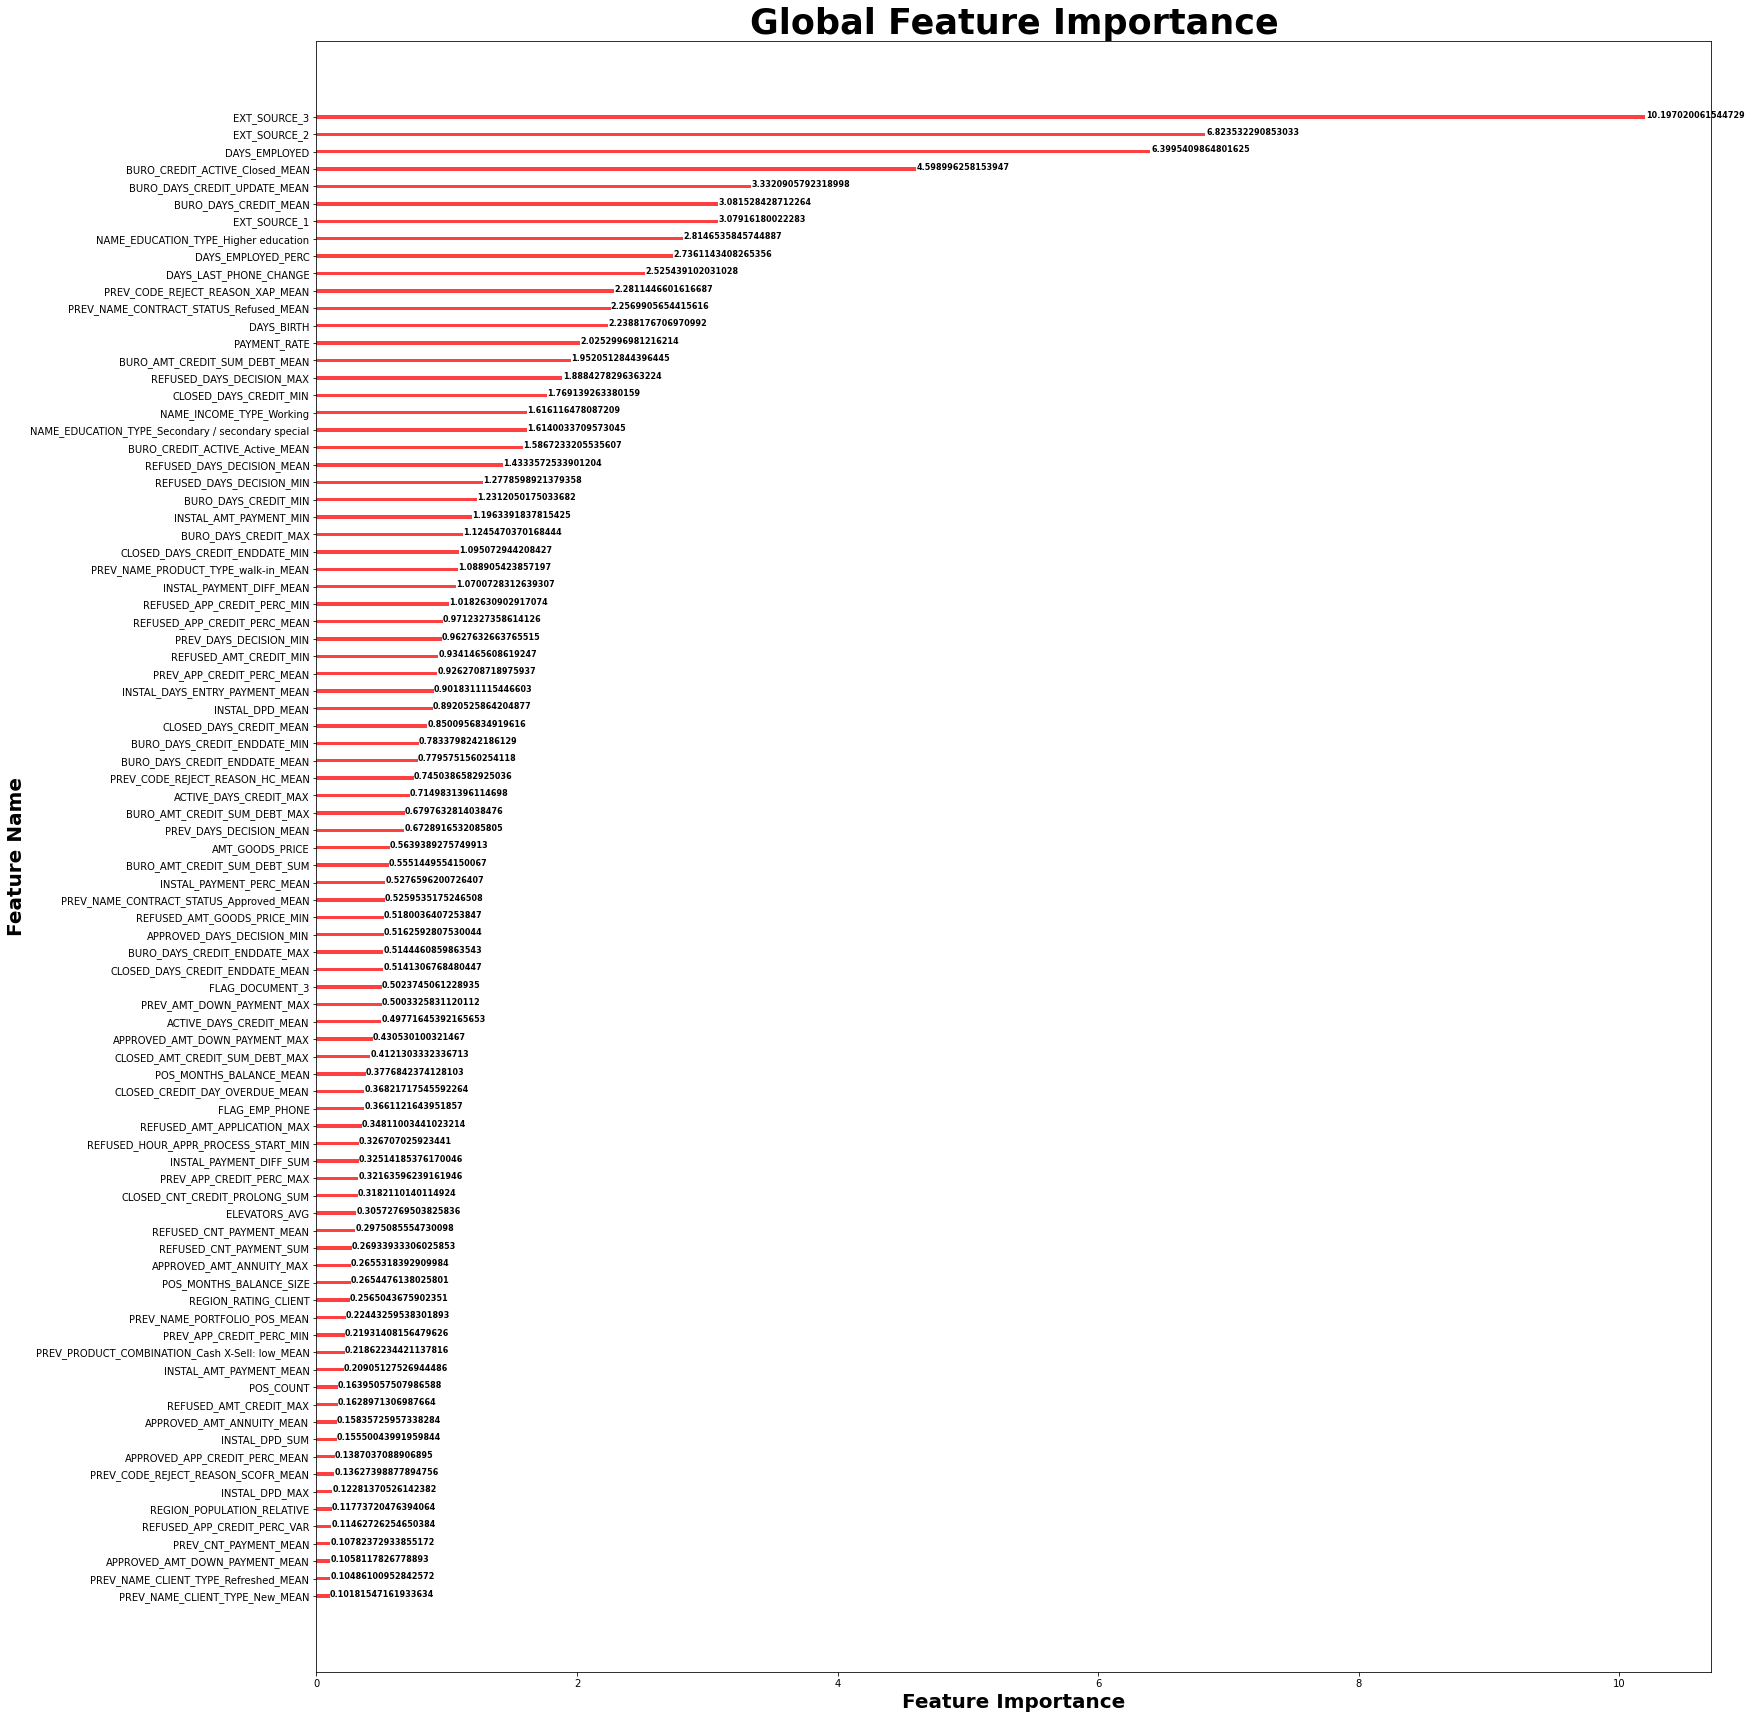

In [ ]:
feature_importance = model_random_forest.feature_importances_
features_names = X_test_sr.columns
feature_importance_global(feature_importance, features_names)

<p style="text-align:justify">
Feature importance local :
</p>

In [ ]:
model = model_random_forest
X_testlo = X_test_sr
X_trainlo = X_train_sr
feature_importance_local(X_testlo, X_trainlo, model) 

In [ ]:
jhjhb

### 3.3. model_gradient_boosting_classifier


In [ ]:
model_gradient_boosting_classifier = GradientBoostingClassifier()
model_gradient_boosting_classifier.fit(X_res, y_res)

GradientBoostingClassifier()

In [ ]:

y_predicted_gbc = pd.Series(model_gradient_boosting_classifier.predict(X_test))
y_predicted_gbc.value_counts()

0    48706
1       38
dtype: int64

In [ ]:
model_gradient_boosting_classifier.fit(X_train, y_train)
y_predicted_gbc = pd.Series(model_gradient_boosting_classifier.predict(X_test))
y_predicted_gbc.value_counts()


0    48653
1       91
dtype: int64

<p style="text-align:justify">
On remarque ici que l'équilibrage pour ce modèle est mieux sans la méthode SMOTE. </p>

<p style="text-align:justify">
Calculer les scores :
</p>

In [ ]:
X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
model_gradient_boosting_classifier.fit(X_train_sg, y_train_sg)
y_predicted_sg = model_gradient_boosting_classifier.predict(X_test_sg)
y_true_sg = y_test_sg
f1_score(y_true_sg, y_predicted_sg)

0.0381940351290817

In [ ]:
roc_auc_score(y_true_sg, model_gradient_boosting_classifier.predict_proba(X_test_sg)[:, 1])

0.7695709276011393

In [ ]:
cost(y_true_sg, y_predicted_sg)

0.018013709548860196

<p style="text-align:justify">
Feature importance globale :
</p>

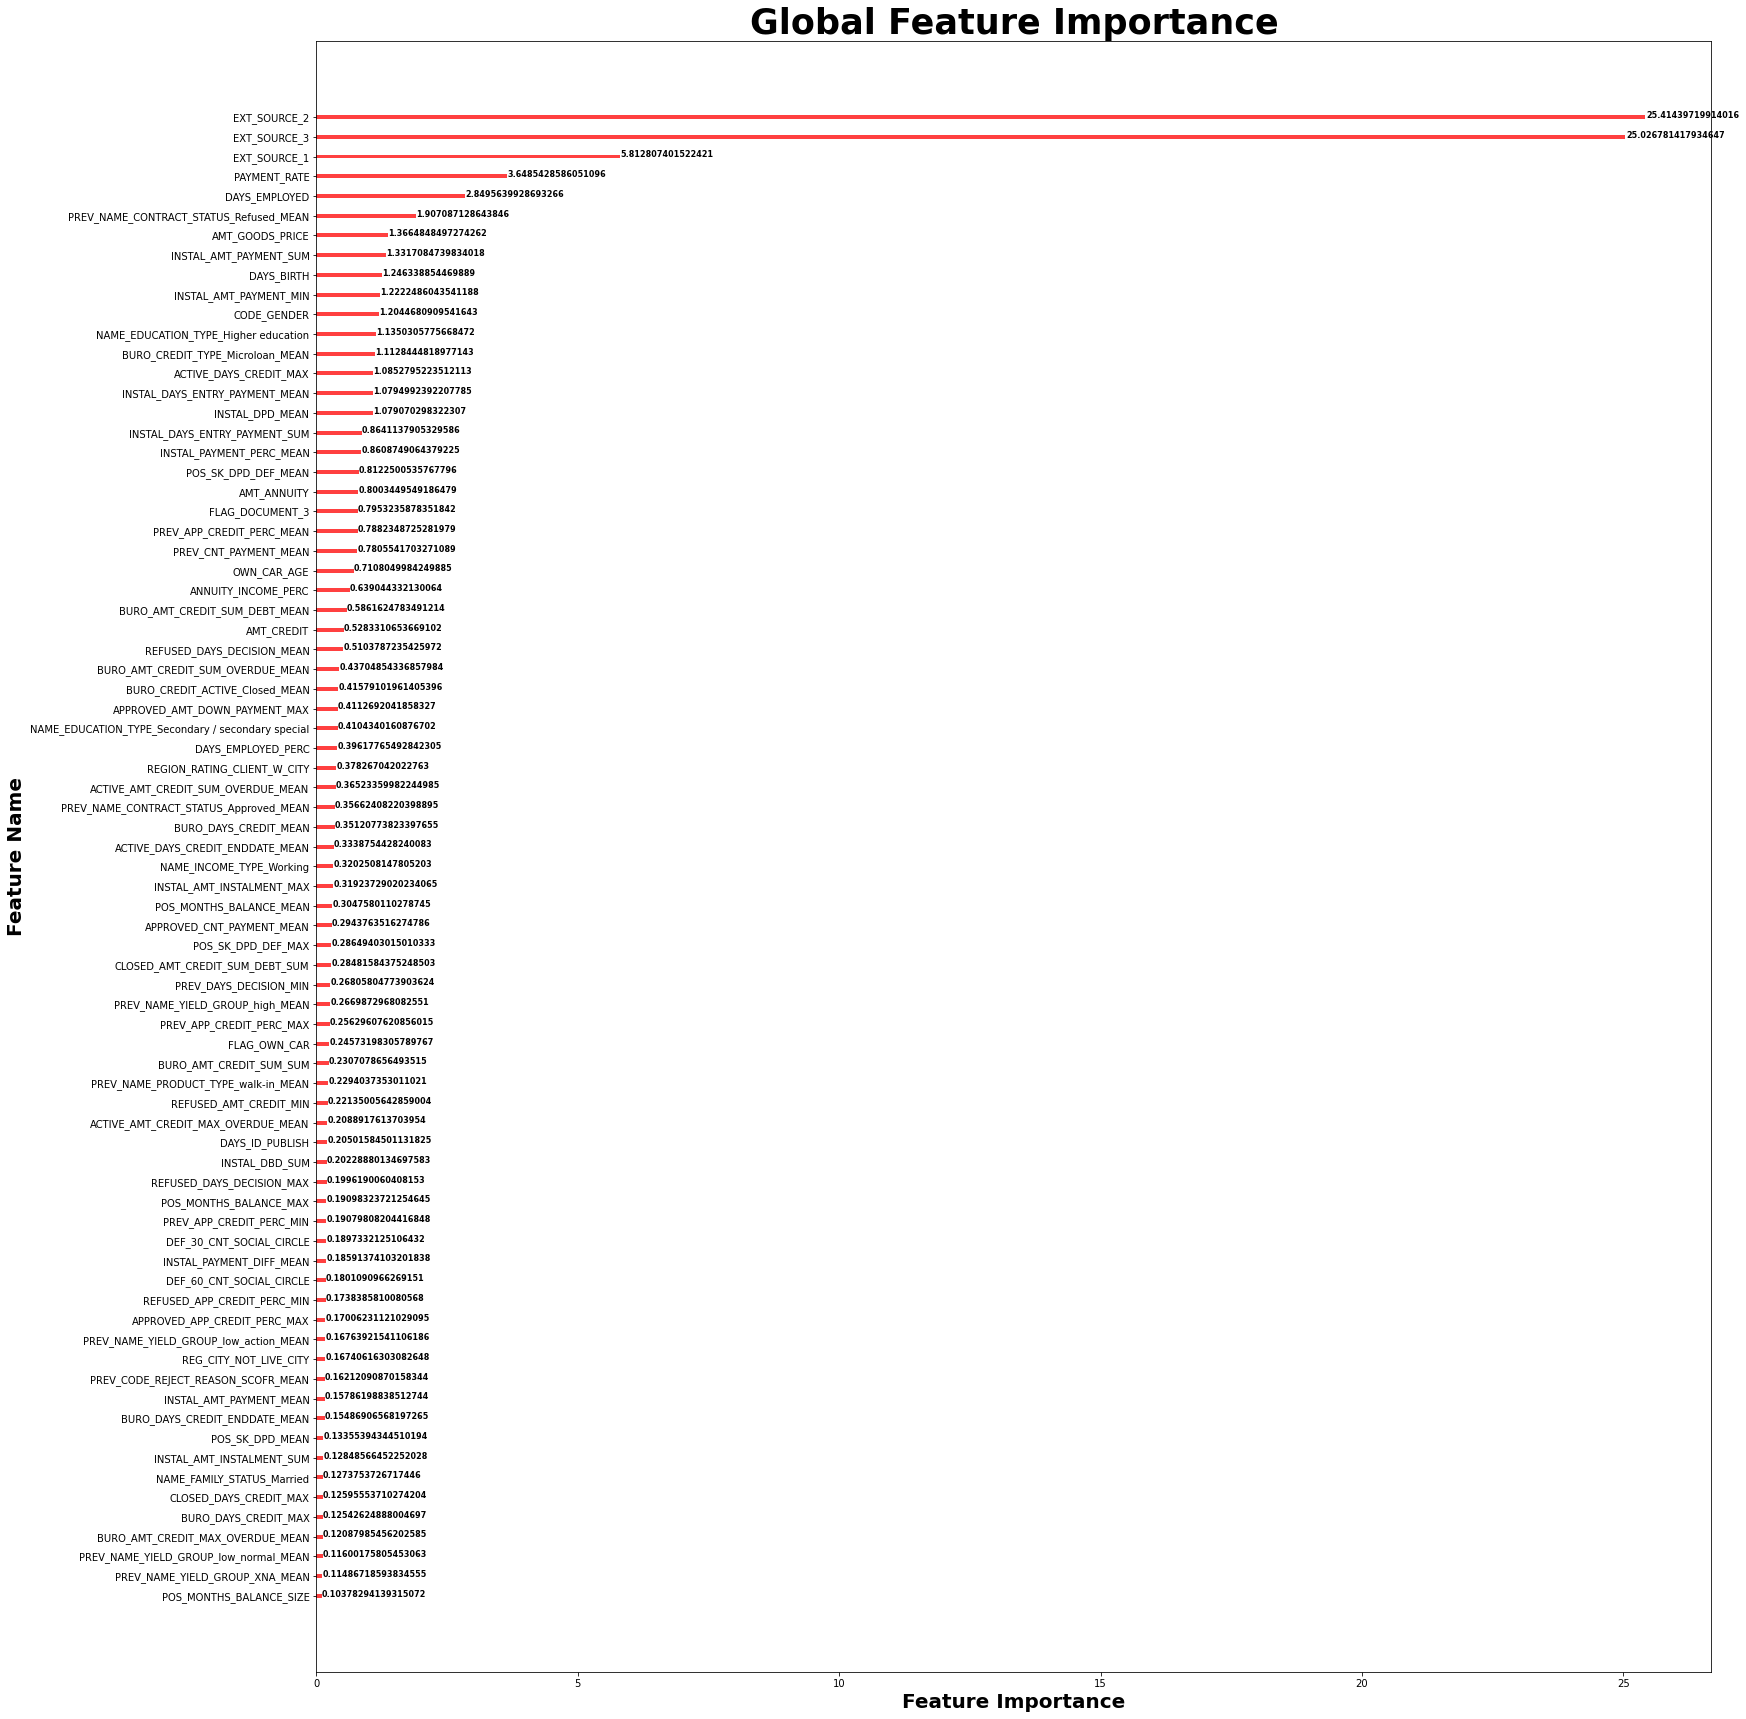

In [ ]:
feature_importance = model_gradient_boosting_classifier.feature_importances_
features_names = X_test_sg.columns
feature_importance_global(feature_importance, features_names)

<p style="text-align:justify">
Feature importance local :
</p>

In [ ]:
model = model_gradient_boosting_classifier
X_testlo = X_test_sg
X_trainlo = X_train_sg
feature_importance_local(X_testlo, X_trainlo, model)

In [ ]:
;l,l;l

NameError: name 'l' is not defined

## 4. Tracker les modeles et creation du registre avec Mlflow

<p style="text-align:justify">
Le but est de trouver avec mlflow les meilleurs paramètres en utilisant les scores comme des métriques d'évaluation. C'est à dire, trouver les meilleurs paramètres pour améliorer les scores. Dans notre cas plus le score est élevé, la qualité sera mieux. Et c'est validé pour les trois scores f1_score, roc_auc_score, et le score de la fonction cout métier. Pour chaque modèle un experiment a été créé, et un score différent choisi. Si vous souhaitez vous pouvez changer le score choisi en changeant mlflow.log_metric() et la valeur de 'loss'. La création du registre du modèle est pour les meilleurs paramètres qui donnent le meilleur score dans notre cas.

<p style="text-align:justify">
Importer et ouvrir Mlflow
</p>

In [ ]:
import mlflow
# mlflow ui
mlflow.set_tracking_uri('http://127.0.0.1:5000')

### 4.1. Mlflow_xgb

<p style="text-align:justify">
Créer un experiment pour xgb et trouver les meilleurs paramètres
</p>

In [ ]:
mlflow.create_experiment("model_xgb", artifact_location='http://127.0.0.1:5000')
model_xgb_id = mlflow.get_experiment_by_name('model_xgb').experiment_id

In [ ]:
def objective_xgb(params):
    
    with mlflow.start_run(experiment_id=model_xgb_id, nested=True): 
        mlflow.set_tag('model', 'model_xgb')
        mlflow.log_params(params)
        model_xgb = xgb.XGBClassifier(**params)
        X_train_sx, X_test_sx, y_train_sx, y_test_sx = train_test_split(X_res, y_res, test_size=0.33, random_state=42)
        model_xgb.fit(X_train_sx, y_train_sx)
        y_predicted_sx = model_xgb.predict(X_test_sx)
        y_true_sx = y_test_sx
        f1_score_ = f1_score(y_true_sx, y_predicted_sx)
        roc_auc_score_ = roc_auc_score(y_true_sx, model_xgb.predict_proba(X_test_sx)[:, 1])
        cost_ = cost(y_true_sx, y_predicted_sx)
        #mlflow.log_metric('f1_score', f1_score_)
        mlflow.log_metric('roc_auc_score', roc_auc_score_)
        #mlflow.log_metric('cost', cost_)
    return {'status':STATUS_OK, 'loss':roc_auc_score_}

In [ ]:
search_space_xgb = { 
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate' : hp.loguniform('learning_rate', -3, 0),
    'reg_alpha' : hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda' : hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight' : hp.loguniform('min_child_weight', -1, 3),
    'seed' : 42
}

In [ ]:
with mlflow.start_run(experiment_id=model_xgb_id):
    best_result = fmin(
        fn=objective_xgb,
        space=search_space_xgb,
        algo=tpe.suggest,
        max_evals=5,
        trials=Trials()
        )

100%|██████████| 5/5 [1:42:39<00:00, 1231.97s/trial, best loss: 0.9798255949779193]


Création du registre du modèle

In [ ]:
model_uri_xgb = 'http://127.0.0.1:5000/#/experiments/790096301531283439/runs/0903d3249529421681c06be4a7905bcb'
mv_xgb = mlflow.register_model(model_uri_xgb, "Best_parameters_xgb")

Successfully registered model 'Best_parameters_xgb'.
2023/02/21 16:57:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Best_parameters_xgb, version 1
Created version '1' of model 'Best_parameters_xgb'.


### 4.2. Mlflow_random_forest

<p style="text-align:justify">
Créer un experiment pour random forest et trouver les meilleurs paramètres
</p>

In [ ]:
mlflow.create_experiment("model_random_forest", artifact_location='http://127.0.0.1:5000')
model_random_forest_id = mlflow.get_experiment_by_name('model_random_forest').experiment_id

In [ ]:
def objective_random_forest(params):
    
    with mlflow.start_run(experiment_id=model_random_forest_id, nested=True): 
        mlflow.set_tag('model', 'model_random_forest')
        mlflow.log_params(params)
        model_random_forest = RandomForestClassifier(**params)
        X_train_sr, X_test_sr, y_train_sr, y_test_sr = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
        model_random_forest.fit(X_train_sr, y_train_sr)
        y_predicted_sr = model_random_forest.predict(X_test_sr)
        y_true_sr = y_test_sr
        f1_score_ = f1_score(y_true_sr, y_predicted_sr)
        roc_auc_score_ = roc_auc_score(y_true_sr, model_random_forest.predict_proba(X_test_sr)[:, 1])
        cost_ = cost(y_true_sr, y_predicted_sr)
        mlflow.log_metric('f1_score', f1_score_)
        #mlflow.log_metric('roc_auc_score', roc_auc_score_)
        #mlflow.log_metric('cost', cost_)
    return {'status':STATUS_OK, 'loss':f1_score_}

In [ ]:
search_space_random_forest = { 
    'n_estimators' : scope.int(hp.quniform('n_estimators', 10, 100, 1)),
    'max_features' : hp.choice('max_features', ['sqrt', 'log2']),
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'class_weight' : hp.choice('class_weight', ['balanced', 'balanced_subsample'])
}

In [ ]:
with mlflow.start_run(experiment_id=model_random_forest_id):
    best_result = fmin(
        fn=objective_random_forest,
        space=search_space_random_forest,
        algo=tpe.suggest,
        max_evals=20,
        trials=Trials()
        )

100%|██████████| 20/20 [20:32<00:00, 61.63s/trial, best loss: 0.0014668133480014668]


Création du registre du modèle


In [ ]:
model_uri_rf = 'http://127.0.0.1:5000/#/experiments/745933057874562526/runs/f6a79c05da7c42a08193bf663aaed56d'
mv_rf = mlflow.register_model(model_uri_rf, "Best_parameters_random_forest")

Successfully registered model 'Best_parameters_random_forest'.
2023/02/21 16:58:46 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Best_parameters_random_forest, version 1
Created version '1' of model 'Best_parameters_random_forest'.


### 4.3. Mlflow_gradient_boosting_classifier


<p style="text-align:justify">
Créer un experiment pour gradient boosting classifier et trouver les meilleurs paramètres
</p>

In [ ]:
mlflow.create_experiment("model_gradient_boosting_classifier", artifact_location='http://127.0.0.1:5000')
model_gradient_boosting_classifier_id = mlflow.get_experiment_by_name('model_gradient_boosting_classifier').experiment_id

In [ ]:
def objective_gradient_boosting_classifier(params):
    
    with mlflow.start_run(experiment_id=model_gradient_boosting_classifier_id, nested=True): 
        mlflow.set_tag('model', 'model_gradient_boosting_classifier')
        mlflow.log_params(params)
        model_gradient_boosting_classifier = GradientBoostingClassifier(**params)
        X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
        model_gradient_boosting_classifier.fit(X_train_sg, y_train_sg)
        y_predicted_sg = model_gradient_boosting_classifier.predict(X_test_sg)
        y_true_sg = y_test_sg
        f1_score_ = f1_score(y_true_sg, y_predicted_sg)
        roc_auc_score_ = roc_auc_score(y_true_sg, model_gradient_boosting_classifier.predict_proba(X_test_sg)[:, 1])
        cost_ = cost(y_true_sg, y_predicted_sg)
        mlflow.log_metric('f1_score', f1_score_)
        #mlflow.log_metric('roc_auc_score', roc_auc_score_)
        mlflow.log_metric('cost', cost_)
    return {'status':STATUS_OK, 'loss':cost_}

In [ ]:
search_space_gradient_boosting_classifier = { 
    'learning_rate' : hp.loguniform('learning_rate', 0, 3),
    'n_estimators' : scope.int(hp.quniform('n_estimators', 1, 25, 1)),
    'criterion' : hp.choice('criterion', ['friedman_mse', 'squared_error']),
    'max_depth' : scope.int(hp.quniform('max_depth', 1, 5, 1))
}

In [ ]:
with mlflow.start_run(experiment_id=model_gradient_boosting_classifier_id):
    best_result = fmin(
        fn=objective_gradient_boosting_classifier,
        space=search_space_gradient_boosting_classifier,
        algo=tpe.suggest,
        max_evals=20,
        trials=Trials()
        )

100%|██████████| 20/20 [47:49<00:00, 143.47s/trial, best loss: -5.465135026199113]  


Création du registre du modèle


In [1]:
model_uri_gbc = 'http://127.0.0.1:5000/#/experiments/725349370880932030/runs/6164c017b113400581f2b0c82a493fe9'
mv_gbc = mlflow.register_model(model_uri_gbc, "Best_parameters_gradient_boosting_classifier")

NameError: name 'mlflow' is not defined

## 5. Création du dashboard et déploiement

<p style="text-align:justify">
Le meilleur modèle parmi les trois qu'on a testé est le modèle xgb.XGBClassifier. Parce que ce modèle possède des scores élevées comparées aux scores des autres modèles et on s'intéresse en particulier à avoir des scores élevées notamment pour f1_score et roc_auc_score.
</p>

<p style="text-align:justify">
Préparer les données pour le dashboard :
</p>

In [ ]:
X_train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 100002 to 456255
Columns: 654 entries, CODE_GENDER to INSTAL_COUNT
dtypes: float64(654)
memory usage: 1.5 GB


<p style="text-align:justify">
En réalité pour les étapes suivantes, le github n'accepte pas un mémoire de plus de 25mb. Donc, un échantillon qui ne dépasse pas le mémoire de 25mb va être pris. C'est notamment pour nous permettre de continuer les étapes suivantes de ce projet.
</p>

In [31]:
X_train_dashboard = X_train.sample(n=int(25/1500*len(X_train)-250), random_state=42)
X_train_dashboard

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
369780              1.0           0.0              0.0           2.0   
405321              1.0           0.0              1.0           0.0   
142233              0.0           0.0              1.0           0.0   
423634              0.0           1.0              0.0           0.0   
271981              1.0           0.0              0.0           0.0   
...                 ...           ...              ...           ...   
379956              1.0           0.0              1.0           0.0   
109493              1.0           0.0              0.0           0.0   
366136              1.0           0.0              0.0           0.0   
431776              0.0           1.0              0.0           0.0   
415700              1.0           0.0              0.0           0.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
369780               72000.0    198666.0      15696.0         175500.0   
405321              221400.0    247500.0       9814.5         247500.0   
142233              360000.0    521136.0      54855.0         495000.0   
423634              360000.0    824917.5      39816.0         724500.0   
271981              135000.0    628114.5      22689.0         477000.0   
...                      ...         ...          ...              ...   
379956              157500.0    500211.0      26779.5         463500.0   
109493               67500.0   1125000.0      44617.5        1125000.0   
366136              202500.0    835380.0      42651.0         675000.0   
431776              171000.0    513000.0      19008.0         513000.0   
415700               90000.0    547344.0      19791.0         472500.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
369780                        0.025164     -9267.0   -2602.000000   
405321                        0.015221    -10916.0    -810.000000   
142233                        0.046220    -10066.0   -1273.000000   
423634                        0.046220    -18698.0   -5153.000000   
271981                        0.018801    -18162.0   -7076.000000   
...                                ...         ...            ...   
379956                        0.014464    -19653.0   -2396.675703   
109493                        0.035792    -14831.0   -3769.000000   
366136                        0.030755    -20088.0   -1548.000000   
431776                        0.022625    -13234.0    -127.000000   
415700                        0.018634    -18138.0    -192.000000   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
369780                 -372.0           -785.0    12.023766         1.0   
405321                 -532.0          -3534.0    12.023766         1.0   
142233                -4059.0          -2511.0    12.023766         1.0   
423634                -8905.0          -2242.0     6.000000         1.0   
271981                -7108.0          -1522.0    12.023766         1.0   
...                       ...              ...          ...         ...   
379956                -2134.0          -3162.0    12.023766         1.0   
109493                -7209.0          -4294.0    12.023766         1.0   
366136                -4418.0          -3487.0    12.023766         1.0   
431776                -2876.0          -4422.0     1.000000         1.0   
415700               -10429.0          -1678.0    12.023766         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
369780                 1.0              0.0               1.0         0.0   
405321 

In [ ]:
X_train_dashboard.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4875 entries, 369780 to 415700
Columns: 654 entries, CODE_GENDER to INSTAL_COUNT
dtypes: float64(654)
memory usage: 24.4 MB


<p style="text-align:justify">
Maintenant, on a un échantillon qui ne dépasse pas 25 mb, et bien il faut prendre les données correspondantes pour y_train_dashboard. C'est pour cela, y_train_dashboard est pris de la meme maniére de X_train_dashboard.
</p>

In [32]:
y_train_dashboard = y_train.sample(n=int(25/1500*len(y_train)-250), random_state=42)
y_train_dashboard

SK_ID_CURR
369780    0
405321    0
142233    0
423634    0
271981    0
         ..
379956    0
109493    0
366136    0
431776    0
415700    0
Name: TARGET, Length: 4875, dtype: int32

In [ ]:
y_train_dashboard.info(memory_usage="deep")

<class 'pandas.core.series.Series'>
Int64Index: 4875 entries, 369780 to 415700
Series name: TARGET
Non-Null Count  Dtype
--------------  -----
4875 non-null   int32
dtypes: int32(1)
memory usage: 57.1 KB


<p style="text-align:justify">
Vérifier que les données de y_train_dashboard sont correspondantes avec X_train_dashboard :
</p>

In [ ]:
for index in X_train_dashboard.index == y_train_dashboard.index:
    if index != True:
        print(index)

<p style="text-align:justify">
Pour X_test ce n'est pas important que les données se correspondent :
</p>

In [49]:
X_test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48744 entries, 100001 to 456250
Columns: 654 entries, CODE_GENDER to INSTAL_COUNT
dtypes: float64(654)
memory usage: 243.6 MB


In [51]:
X_test_dashboard = X_test.sample(n=int(25/243*len(X_test)-250), random_state=42)
X_test_dashboard

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
208550              0.0           1.0              0.0           2.0   
173779              1.0           0.0              0.0           0.0   
365820              1.0           1.0              1.0           0.0   
144092              0.0           0.0              0.0           0.0   
291599              0.0           0.0              1.0           1.0   
...                 ...           ...              ...           ...   
304779              1.0           0.0              0.0           1.0   
309526              1.0           0.0              0.0           1.0   
365408              1.0           0.0              0.0           0.0   
290379              0.0           0.0              0.0           1.0   
167052              1.0           0.0              0.0           1.0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
208550              450000.0    854896.5      36351.0         702000.0   
173779               67500.0    296280.0      19062.0         225000.0   
365820              135000.0    339948.0      35694.0         315000.0   
144092              256500.0    609898.5      31270.5         526500.0   
291599              180000.0    450000.0      22977.0         450000.0   
...                      ...         ...          ...              ...   
304779              157500.0    667237.5      36324.0         576000.0   
309526              135000.0    332946.0      18189.0         238500.0   
365408              268200.0    247500.0      12766.5         247500.0   
290379              180000.0    414612.0      21298.5         297000.0   
167052               90000.0    360000.0      18508.5         360000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
208550                        0.032561    -11348.0   -1149.000000   
173779                        0.009175    -19852.0   -2396.675703   
365820                        0.024610    -15138.0   -4891.000000   
144092                        0.002042    -15214.0   -2773.000000   
291599                        0.018029    -15806.0   -5816.000000   
...                                ...         ...            ...   
304779                        0.008866    -16556.0    -310.000000   
309526                        0.007120     -9891.0   -1618.000000   
365408                        0.018209    -19681.0   -1240.000000   
290379                        0.018801    -10677.0   -2290.000000   
167052                        0.031329    -13622.0   -5713.000000   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
SK_ID_CURR                                                                
208550                -5443.0          -3953.0    14.000000         1.0   
173779                 -192.0          -3237.0    12.023766         1.0   
365820                -9273.0          -4450.0     7.000000         1.0   
144092                -2075.0          -4943.0    12.023766         1.0   
291599                -1188.0          -5943.0    12.023766         1.0   
...                       ...              ...          ...         ...   
304779                -2940.0           -100.0    12.023766         1.0   
309526                -2400.0          -2578.0    12.023766         1.0   
365408                 -993.0          -3038.0    12.023766         1.0   
290379                -4591.0           -825.0    12.023766         1.0   
167052                 -111.0          -4810.0    12.023766         1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
208550                 1.0              0.0               1.0         0.0   
173779 

In [52]:
X_test_dashboard.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4764 entries, 208550 to 167052
Columns: 654 entries, CODE_GENDER to INSTAL_COUNT
dtypes: float64(654)
memory usage: 23.8 MB


<p style="text-align:justify">
Sauvegarder le modèle xgb entraîné avec ses meilleurs paramètres trouvés par Mlflow : 
</p>

In [53]:
model_xgb = xgb.XGBClassifier(
    learning_rate = 0.13340120276728681,
    max_depth = 43,
    min_child_weight = 1.5589983674569985,
    reg_alpha = 0.08048825852598339,
    reg_lambda = 0.006187471945504702,
    seed = 42
)

In [54]:
model_xgb.fit(X_train_dashboard, y_train_dashboard)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.13340120276728681, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=43, max_leaves=0,
              min_child_weight=1.5589983674569985, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0.08048825852598339, reg_lambda=0.006187471945504702, ...)

In [55]:
filename = "model_xgb_dashb.joblib"
# save model
joblib.dump(model_xgb, filename)

['model_xgb_dashb.joblib']

<p style="text-align:justify">
Sauvegarder les données des clients avec leurs numéros :
</p>

In [56]:
#numéro du client
X_test_dashboard.index

Int64Index([208550, 173779, 365820, 144092, 291599, 418609, 398791, 202661,
            185171, 111761,
            ...
            101922, 198099, 221264, 416305, 390851, 304779, 309526, 365408,
            290379, 167052],
           dtype='int64', name='SK_ID_CURR', length=4764)

In [57]:
X_test_dashboard.to_csv('X_test_dashboard.csv' )
X_train_dashboard.to_csv('X_train_dashboard.csv' )
y_train_dashboard.to_csv('y_train_dashboard.csv' )